# Load Datasets

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

+ X_label IMG

In [2]:
def load(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size=(150, 150))
    return img

In [32]:
import sklearn

d_path = 'D:\AlbumCover/'
img_dataset_cache = pd.read_csv('./dataset/album_data_0522.csv')
img_dataset = img_dataset_cache.copy()
imsi_idx = img_dataset[(img_dataset["Brass & Military"] == 1) | (img_dataset["Children's"] == 1) | (img_dataset["Classical"] == 1) | (img_dataset["Non-Music"] == 1) | (img_dataset["Stage & Screen"] == 1)].index
img_dataset = img_dataset.drop(imsi_idx)
img_dataset = sklearn.utils.shuffle(img_dataset)

In [33]:
img_arr = None
count = 0
for path in img_dataset['path']:
    if img_arr is None:
        img_arr = np.expand_dims(load(d_path + path), axis=0)
    else:
        img_arr = np.append(img_arr, np.expand_dims(load(d_path + path), axis=0), axis=0)
    count += 1
    print(count)
    if count > 4999:
        break

np.save('img_np_arr', img_arr)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [5]:
# check np array is well defined
img_arr.shape

(5000, 150, 150, 3)

+ y_label

In [34]:
y_data = img_dataset.iloc[:,9:]
y_data = y_data.drop(["Brass & Military", "Children's", "Classical", "Non-Music", "Stage & Screen"], axis=1)
y_out = np.array(y_data)
y_out = y_out[:5000]
img_arr = img_arr.astype('float64')

In [7]:
y_out.shape

(5000, 10)

In [6]:
# y_data = pd.read_csv('./dataset/y_label.csv')

# y_out = np.array(y_data)

# img_arr = img_arr.astype('float64')

---

# ResNet Modeling w/ BP-MLL

Make Model using keras functional api

In [8]:
# is_50 : True --> resnet_50
# is_plain :True --> no skip connection    
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,is_50 = False,is_plain = False):
    # 입력 레이어
    x = input_layer
    if not is_50:
    # CNN 레이어
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]    

                if identity_channel != channel:
                    identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
                # skip connection
                x = keras.layers.Add()([x,identity])   
            else:
                pass
    else :
        identity = x
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_1_conv{cnn_num}'
        )(x)
        x = keras.layers.Conv2D(
            filters=channel * 4,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_2_conv{cnn_num}'
        )(x)
        if not is_plain:
            identity_channel = identity.shape.as_list()[-1]    

            if identity_channel != channel:
                identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
            # skip connection
            x = keras.layers.Add()([x,identity])   
        else:
            pass
    #     Max Pooling 레이어
    # 마지막 블록 뒤에는 pooling을 하지 않음
    if identity.shape[1] != 1:        
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name=f'block{block_num}_pooling'
        )(x)

    return x

However, act.func. of last layer is not 'softmax' but 'sigmoid'

In [9]:
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,is_50 = False, is_plain = False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]
        num_classes = 10
        
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    #conv1층
    output = keras.layers.Conv2D(filters=64,
                       kernel_size = (2,2),
                       strides = 2,
                         padding = 'valid')(output)
    output = keras.layers.BatchNormalization()(output)
    
    #conv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2,)(output)    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )    
    output = keras.layers.AveragePooling2D(padding = 'same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu', name='fc1')(output)    
    output = keras.layers.Dense(num_classes, activation='sigmoid', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [10]:
NUM_CLASSES = 10

In [11]:
model = build_resnet(input_shape=(150,150,3), num_classes=NUM_CLASSES, is_plain=True)

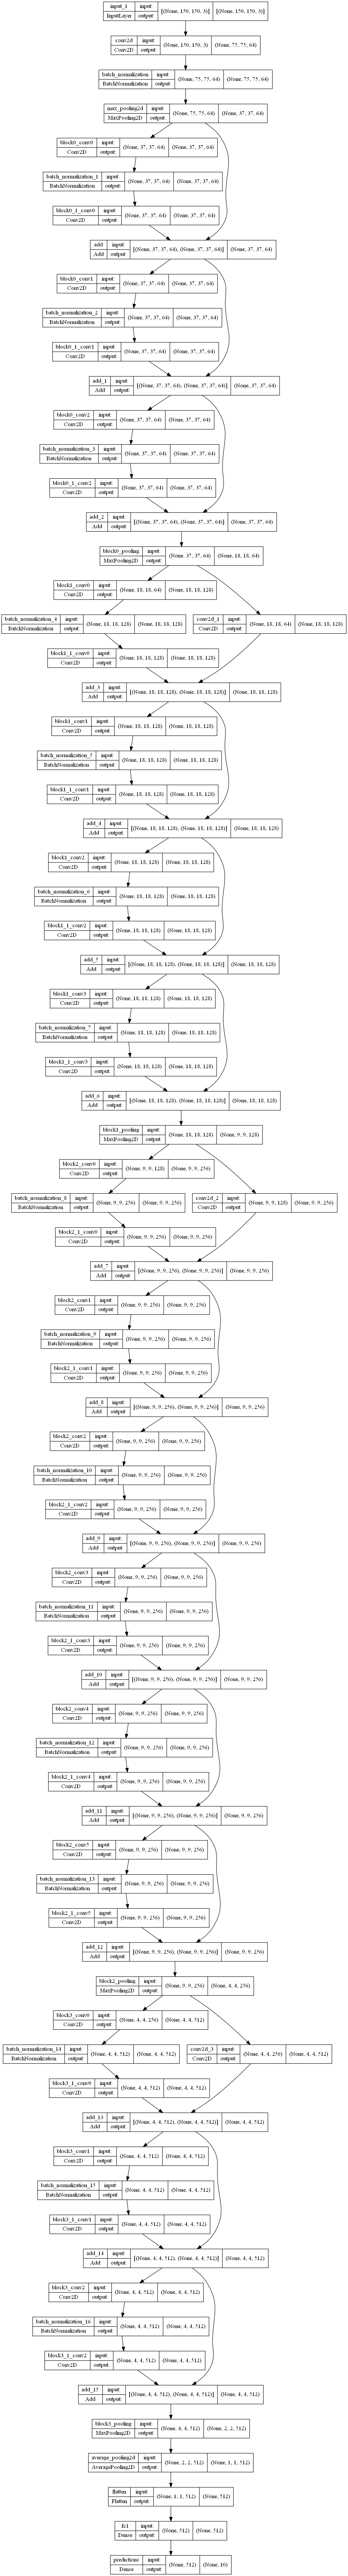

In [12]:
# you can see model summary

tf.keras.utils.plot_model(model, show_shapes=True)

Compiling the Model

In [35]:
from bpmll import bp_mll_loss
import tensorflow as tf
from sklearn.metrics import log_loss, f1_score # not in use right now

# 성능 기반 스케줄링
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)


model.compile(loss = 'binary_crossentropy',
              optimizer= 'adagrad',
              metrics=[tf.compat.v1.losses.log_loss, 'accuracy']

              )

# model.compile(loss = tf.nn.softmax_cross_entropy_with_logits,
#               optimizer= optimizer,
#               metrics=['CategoricalCrossentropy', 'accuracy'])

In [14]:
import sklearn

img_arr_s = sklearn.utils.shuffle(img_arr, random_state=123)
y_out_s = sklearn.utils.shuffle(y_out, random_state=123)

weigh = np.array([1/42, 1/89, 1/112, 1/370, 1/135, 1/250, 1/47, 1/347, 1/51, 1/230, 1/50])
weigh = weigh * 1205 / 11
cw = {0:weigh[0], 1:weigh[1], 2:weigh[2], 3:weigh[3], 4:weigh[4], 5:weigh[5], 6:weigh[6], 7:weigh[7], 8:weigh[8], 9:weigh[9], 10:weigh[10]}

In [30]:
#with tf.device("/device:GPU:0"):
history = model.fit(
x=img_arr,
y=y_out,
validation_split=0.2,
epochs=400,
callbacks=[lr_scheduler, tf.keras.callbacks.EarlyStopping(patience=10)],
class_weight = cw,
batch_size=32
)

Epoch 1/400
125/125 [==============================] - 12s 81ms/step - loss: 0.0399 - log_loss: 0.0431 - accuracy: 0.8315 - val_loss: 0.5600 - val_log_loss: 0.5618 - val_accuracy: 0.2390 - lr: 0.0010
Epoch 2/400
125/125 [==============================] - 10s 81ms/step - loss: 0.0368 - log_loss: 0.0423 - accuracy: 0.8418 - val_loss: 0.5673 - val_log_loss: 0.5691 - val_accuracy: 0.2380 - lr: 0.0010
Epoch 3/400
125/125 [==============================] - 10s 82ms/step - loss: 0.0356 - log_loss: 0.0409 - accuracy: 0.8365 - val_loss: 0.5756 - val_log_loss: 0.5772 - val_accuracy: 0.2390 - lr: 0.0010
Epoch 4/400
125/125 [==============================] - 10s 79ms/step - loss: 0.0350 - log_loss: 0.0404 - accuracy: 0.8388 - val_loss: 0.5785 - val_log_loss: 0.5801 - val_accuracy: 0.2400 - lr: 0.0010
Epoch 5/400
125/125 [==============================] - 10s 80ms/step - loss: 0.0336 - log_loss: 0.0391 - accuracy: 0.8407 - val_loss: 0.5808 - val_log_loss: 0.5824 - val_accuracy: 0.2410 - lr: 5.0000e

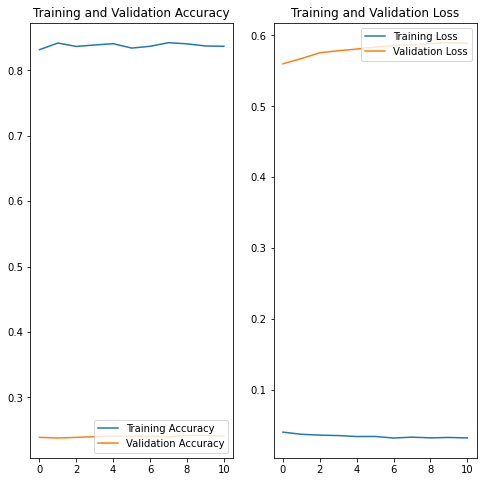

In [31]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(11)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
k = model.predict(img_arr[260:263])

In [53]:
np.set_printoptions(formatter={'float_kind': lambda x: "{0:0.4f}".format(x)})



In [31]:
k 

array([[0.03440069, 0.09901544, 0.01814081, 0.15511066, 0.50941813,
        0.10593298, 0.02063033, 0.05752189, 0.12222853, 0.08644311],
       [0.01836892, 0.0624362 , 0.04514047, 0.46582073, 0.13840081,
        0.48399326, 0.03658346, 0.09091216, 0.02337698, 0.20591444],
       [0.04332389, 0.15144657, 0.02753114, 0.26982802, 0.03832465,
        0.25234807, 0.0197471 , 0.15079133, 0.02742974, 0.4981645 ]],
      dtype=float32)

In [32]:
y_out[260:263] > 0.8

array([[False, False, False, False,  True, False, False, False, False,
        False],
       [False, False, False,  True, False,  True,  True, False, False,
         True],
       [ True, False, False, False, False, False, False, False, False,
         True]])

In [33]:
for genre in y_data.columns:
    print(genre, ': ', len(y_data[y_data[genre] == 1]))

Blues :  531
Electronic :  1579
Folk, World, & Country :  826
Funk&Soul :  3284
Hip Hop :  2152
Jazz :  2753
Latin :  335
Pop :  1984
Reggae :  582
Rock :  3308


In [34]:
model.save('./models/ResNet50_0525.h5')
# github 문제로 D드라이브에 저장했음

In [40]:
test_arr = None
count = 0
for path in img_dataset['path']:
    if count > 7000:
        print(path)
        if test_arr is None:
            test_arr = np.expand_dims(load(d_path + path), axis=0)
        else:
            test_arr = np.append(test_arr, np.expand_dims(load(d_path + path), axis=0), axis=0)
    count += 1
    print(count)
    if count > 7020:
        break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [56]:
k = model.predict(test_arr)

for i in k:
    print(i)

[0.0256 0.0748 0.0544 0.3698 0.2776 0.3038 0.0235 0.0749 0.0157 0.3039]
[0.0684 0.0392 0.0898 0.4329 0.2506 0.2046 0.0075 0.1337 0.0421 0.1517]
[0.0363 0.1098 0.0889 0.1962 0.1144 0.2021 0.0164 0.0952 0.0330 0.1636]
[0.0186 0.0317 0.0351 0.3653 0.5007 0.2927 0.0016 0.0303 0.1350 0.0936]
[0.0338 0.0744 0.0469 0.3731 0.1085 0.1841 0.0334 0.1940 0.0323 0.4101]
[0.0731 0.1246 0.1015 0.2920 0.0456 0.2342 0.0196 0.2806 0.0649 0.2849]
[0.1078 0.1835 0.1014 0.3195 0.0452 0.2134 0.0231 0.2323 0.0474 0.1789]
[0.0359 0.0438 0.0283 0.1511 0.1232 0.4129 0.0117 0.0796 0.1211 0.6267]
[0.0391 0.1207 0.0689 0.2107 0.1562 0.1494 0.0128 0.1840 0.0488 0.0948]
[0.0589 0.0470 0.0896 0.2259 0.3394 0.1843 0.0159 0.1257 0.0262 0.3237]
[0.0556 0.0571 0.0571 0.3002 0.0848 0.2282 0.0339 0.1216 0.0581 0.1470]
[0.6001 0.0037 0.0000 0.0322 0.1213 0.3494 0.0000 0.0000 0.1238 1.0000]
[0.0392 0.0722 0.1352 0.1191 0.0786 0.3406 0.0280 0.0890 0.0524 0.3587]
[0.0245 0.1675 0.0170 0.1688 0.1321 0.2185 0.0068 0.1412 0.0430 

In [49]:
test_out = np.array(y_data)
test_out = test_out[7001:7021]

In [50]:
test_out

array([[0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]])

In [63]:
for i in range(20):
    print(k[i])
    print(test_out[i])

[0.0256 0.0748 0.0544 0.3698 0.2776 0.3038 0.0235 0.0749 0.0157 0.3039]
[0.0000 1.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000]
[0.0684 0.0392 0.0898 0.4329 0.2506 0.2046 0.0075 0.1337 0.0421 0.1517]
[0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000]
[0.0363 0.1098 0.0889 0.1962 0.1144 0.2021 0.0164 0.0952 0.0330 0.1636]
[0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
[0.0186 0.0317 0.0351 0.3653 0.5007 0.2927 0.0016 0.0303 0.1350 0.0936]
[0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
[0.0338 0.0744 0.0469 0.3731 0.1085 0.1841 0.0334 0.1940 0.0323 0.4101]
[0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000]
[0.0731 0.1246 0.1015 0.2920 0.0456 0.2342 0.0196 0.2806 0.0649 0.2849]
[0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000]
[0.1078 0.1835 0.1014 0.3195 0.0452 0.2134 0.0231 0.2323 0.0474 0.1789]
[0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 

In [48]:
img_dataset.iloc[7001:7021,:]

,master_release,path,dominant_r,dominant_g,dominant_b,gender,age,dominant_race,emotion,Blues,...,"Folk, World, & Country",Funk&Soul,Hip Hop,Jazz,Latin,Non-Music,Pop,Reggae,Rock,Stage & Screen
10646,10180,multi\Electronic+Jazz\10180.jpeg,88,62,52,0,0,0,0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9112,2229160,Rock\2229160.jpeg,125,97,98,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2525,17278,Funk&Soul\17278.jpeg,60,91,93,0,0,0,0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5090,59278,Hip Hop\59278.jpeg,104,78,67,0,0,0,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13813,20915,multi\Rock+Pop\20915.jpeg,127,111,125,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
8503,111912,Rock\111912.jpeg,213,185,159,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8507,11213,Rock\11213.jpeg,161,131,105,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1690,601678,"Folk, World, & Country\601678.jpeg",91,38,44,0,0,0,0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11028,2156965,multi\Electronic+Rock+Pop\2156965.jpeg,236,144,142,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
10011,7603,Rock\7603.jpeg,55,52,50,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
